# 교차 검증과 그리드 서치

## 검증 세트
훈련세트를 한번 더 나누어서 '검증세트 validation set'를 만든다.

In [ ]:
import pandas as pd

wine = pd.read_csv('https://bit.ly/wine_csv_data')

In [ ]:
data = wine[['alcohol', 'sugar', 'pH']].to_numpy()      # 문제
target = wine['class'].to_numpy()                       # 정답(타깃)

In [ ]:
from sklearn.model_selection import train_test_split

# 테스트 세트는 최종 평가시 사용
train_input, test_input, train_target, test_target = train_test_split(
    data, target, test_size=0.2, random_state=42)

In [ ]:
# 훈련 세트(sub)를 훈련 세트(val)와 검증세트로 나눔
sub_input, val_input, sub_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42)

In [ ]:
print(sub_input.shape, val_input.shape, test_input.shape)
# 전체 중 64%, 16%, 20% 정도가 된다....

(4157, 3) (1040, 3) (1300, 3)


In [ ]:
# 아직 교차검증 안들어간 상태로 훈련 세트와 검증 세트의 정확도를 확인해봄
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(sub_input, sub_target)

print(dt.score(sub_input, sub_target))
print(dt.score(val_input, val_target))

0.9971133028626413
0.864423076923077


## 교차 검증

교차 검증을 이용하면 안정적인 검증 점수를 얻고 훈련에 더 많은 데이터를 사용할 수 있다.    
교차 점증은 검증 세트를 떼어 내어 평가하는 과정을 여러번 반복.   
이 점수를 평균하여 최종 검증 점수를 얻는다.   
3-폴드 교차 검증: 훈련 세트를 세 부분으로 나눠서 교차 검증을 수행.

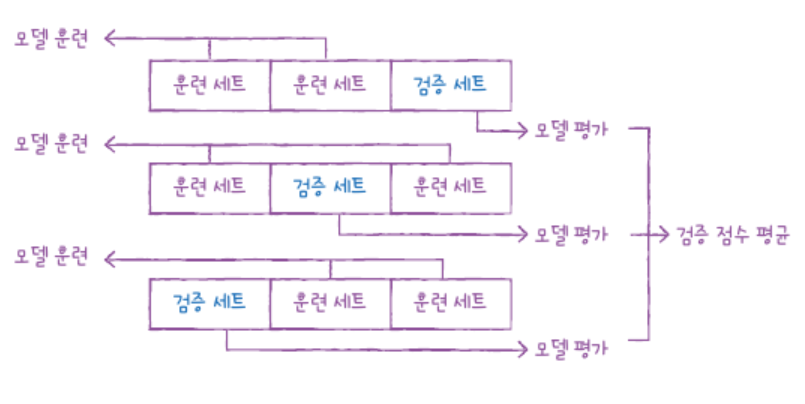

In [10]:
# 교차검증 함수 import 하고 실행 cross_validate(평가할 모델, 훈련(전체) 입력 세트, 훈련(전체) 정답 세트)
from sklearn.model_selection import cross_validate

scores = cross_validate(dt, train_input, train_target)
display(scores)

# fit_time, score_time, test_score 키를 가진 딕셔너리 반환
# fit_time = 모델을 훈련하는 시간
# score_time = 검증하는 시간
# cross_validate() 함수는 기본적으로 5-폴드 교차 검증을 수행하므로, 각 키마다 5개의 숫자를 가지고 있다.
# cv 매개변수에서 폴드 수를 바꿀 수 있음.

{'fit_time': array([0.02607751, 0.00845242, 0.00884867, 0.00879002, 0.00859118]),
 'score_time': array([0.00147963, 0.00113845, 0.00131249, 0.00141859, 0.00122714]),
 'test_score': array([0.86923077, 0.84615385, 0.87680462, 0.84889317, 0.83541867])}

In [11]:
import numpy as np

# 교차 검증의 최종 점수는 test_score 키에 담긴 5개의 점수를 평균하여 얻을 수 있음
print(np.mean(scores['test_score']))

0.855300214703487


### 교차검증 방법1 - cross_validate(cv = 모델 지정)
cross_validate()는 훈련 세트를 섞지 않는다.   
만약 교차 검증을 할 때 훈련 세트를 섞으려면 분할기(splitter)를 지정해야 한다.   
cross_validate() 함수는 기본적으로   
_회귀 모델 - KFold 분할기 / 분류 모델 - StratifiedKFold 사용_

In [12]:
# 앞서 수행한 교차 검증(평균을 따로 구한 과정)은 기본값으로 설정되어 있어 다음과 동일하다.
from sklearn.model_selection import StratifiedKFold

scores = cross_validate(dt, train_input, train_target, cv=StratifiedKFold())
print(np.mean(scores['test_score']))

0.855300214703487


In [13]:
# 훈련 세트를 섞은 후 10-폴드 교차 검증을 수행하려면 다음과 같이 작성
dt = DecisionTreeClassifier(random_state=42)

splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)    # StratifiedKFold()의 매개변수를 제공하기 위해 splitter 매개변수를 만들어 값을 넣어주고,
scores = cross_validate(dt, train_input, train_target, cv=splitter)       # 이후에 cv에 splitter를 넣어준다.
print(np.mean(scores['test_score']))

0.8574181117533719


## 하이퍼파라미터 튜닝
### 교차검증 방법2 - GridSearchCV(사용할 모델, 파라미터 딕셔너리, CPU 갯수 지정)

하이퍼파라미터: 모델이 학습할 수 없어서 사용자가 지정해야 하는 파라미터    
하이퍼파라미터를 튜닝: 매개변수를 바꿔가면서 모델을 훈련하고 교차검증을 수행하고자 함

하이퍼파라미터 값은 '객체.'를 입력한 후 ctrl+space를 누르면 확인할 수 있다.
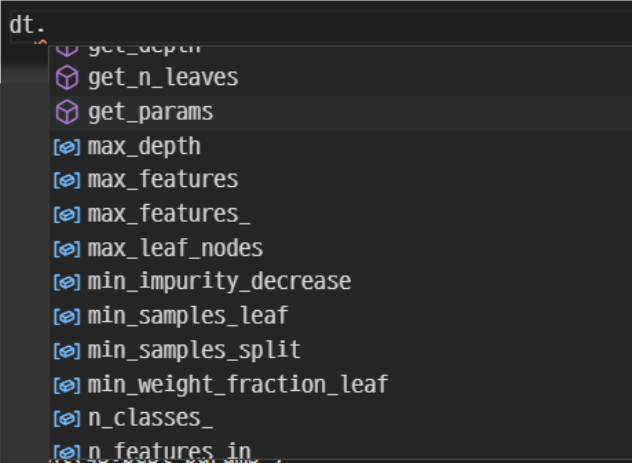

In [14]:
# 그리드 서치(GridSearch) : 매개변수 값을 바꿔가며 가장 적합한 매개변수를 찾기 위한 함수. (for 반복문으로 직접 구현할 필요 없이, 만들어진 함수를 사용하자)
# 탐색할 하이퍼파라미터와 탐색할 값의 리스트를 딕셔너리로 생성

from sklearn.model_selection import GridSearchCV

params = {'min_impurity_decrease': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005]}
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1)   
# 알고리즘은 DecisionTreeClassifier를 사용할 건데, 하이퍼파라미터 리스트는 params에 따르고, 병렬 실행에 사용할 CPU는 전부 다 사용하기(-1)
# 이 설정을 그리드 서치 함수에 넣어서, 이중 for문처럼 이중 알고리즘을 만듦
gs.fit(train_input, train_target) # 학습시키기

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'min_impurity_decrease': [0.0001, 0.0002, 0.0003,
                                                   0.0004, 0.0005]})

In [16]:
dt_best = gs.best_estimator_       # 5-폴드 교차검증을 실시한 결과로, 가장 높은 정확도를 가지는 모델은 best_estimator_ 속성에 들어가 있다.
# 참고: GridSearchCV의 cv(cross validate) 매개변수 기본값은 5, 따라서 min_impurity_decrease 값마다 5-폴드 교차 검증을 수행, 즉 총 25개의 모델을 훈련
print(dt_best.score(train_input, train_target))

0.9615162593804117


최적의 하이퍼파라미터값을 알아보는 방법 1

In [17]:
print(gs.best_params_)       # GridSearch의 결과로, 가장 적합한 하이퍼파라미터 값은 best_params_ 속성에 들어가있다.

{'min_impurity_decrease': 0.0001}


최적의 하이퍼파라미터값을 알아보는 방법 2

In [18]:
print(gs.cv_results_['mean_test_score'])     # 각 매개변수에서 수행한 교차 검증의 평균 점수

[0.86819297 0.86453617 0.86492226 0.86780891 0.86761605]


In [19]:
best_index = np.argmax(gs.cv_results_['mean_test_score'])
print(gs.cv_results_['params'][best_index])

{'min_impurity_decrease': 0.0001}


In [21]:
params = {'min_impurity_decrease': np.arange(0.0001, 0.001, 0.0001),
          'max_depth': range(5, 20, 1),
          'min_samples_split': range(2, 100, 10)
          }
# 최소 불순도 9가지, 최대 깊이 15가지, 최소 샘플 분리 10가지 = 하이퍼파라미터 리스트 총 1,350개
# 기본 5-폴드 교차검증을 수행 = 6,750개의 모델을 수행하고 결과값을 확인함 
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1)
gs.fit(train_input, train_target)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(5, 20),
                         'min_impurity_decrease': array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009]),
                         'min_samples_split': range(2, 100, 10)})

In [22]:
# 최상의 하이퍼파라미터 조합
print(gs.best_params_)

{'max_depth': 14, 'min_impurity_decrease': 0.0004, 'min_samples_split': 12}


In [ ]:
# 최상의 교차검증 점수
print(np.max(gs.cv_results_['mean_test_score']))

0.8683865773302731


### 랜덤 서치

그리드 서치의 단점:   
1. 매개변수의 값이 수치일 때 값의 범위나 간격을 미리 정하기 어려울 수 있음   
2. 너무 많은 매개변수 조건이 있으면 시간이 오래 걸림

랜덤 서치의 보완점: 
- 매개변수 값의 목록을 전달하는 것이 아니라,   
매개변수를 샘플링할 수 있는 확률 분포 객체를 전달,   
이를 활용해서 최적의 하이퍼파라미터 조합과 정확도 결과값을 도출한다.

In [24]:
from scipy.stats import uniform, randint

# uniform과 randint 함수 모두 주어진 범위에서 고르게 값을 뽑는다. = 균등 분포에서 샘플링한다.
# 주의: randint 명칭이 numpy의 것과 같지만, 서로 다른 클래스에 포함되어 있으므로 import 할 때 주의한다.
# randint는 정수값을 랜덤하게 뽑아주고, uniform은 실수를 랜덤하게 뽑아준다.

1. randint

In [26]:
rgen = randint(0, 10)     # 범위가 지정된 객체
print(rgen)               # 샘플링할 수 있는 객체로 만들어질 뿐. 프린트를 한다고 해서 바로 확인할 수 없다.
rgen.rvs(10)              # 해당 객체에 rvs() 함수를 이용해서 몇개를 샘플링 할 지 실행해줘야 한다.

array([0, 2, 5, 6, 7, 4, 5, 9, 7, 4])

In [ ]:
rgen.rvs(1000)          # 0에서 9사이의 숫자 중 랜덤한 숫자가 1000개 뽑아진다.

In [28]:
np.unique(rgen.rvs(1000), return_counts=True)     # return_counts - 각각의 숫자가 몇번 나왔는지 확인

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([112,  97,  97, 106,  92,  95, 108, 101,  92, 100]))

2. uniform

In [29]:
ugen = uniform(0, 1)
ugen.rvs(10)

array([0.60562263, 0.37770034, 0.4027472 , 0.87325578, 0.98452176,
       0.40182097, 0.52651126, 0.85857929, 0.45263458, 0.27866838])

In [30]:
# 파라미터 리스트에 randint()를 사용
params = {'min_impurity_decrease': uniform(0.0001, 0.001),
          'max_depth': randint(20, 50),
          'min_samples_split': randint(2, 25),
          'min_samples_leaf': randint(1, 25),
          }

In [33]:
params

{'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7fe79f0ad8b0>,
 'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen at 0x7fe79f00dee0>,
 'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen at 0x7fe79eee9190>,
 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen at 0x7fe79f00d280>}

scipy의 randint와 uniform을 사용해서 교차검증 + 하이퍼파라미터 튜닝을 하려면   
RandomizedSearchCV를 사용해야 한다.   
RandomizedSearchCV의 n_iter 매개변수를 사용해서 파라미터 샘플링 횟수를 한꺼번에 지정할 수 있다.

랜덤 서치는 그리드 서치보다 교차 검증 수를 줄이면서 넓은 영역을 효과적으로 탐색할 수 있다.

In [31]:
# RandomizedSearchCV를 사용
from sklearn.model_selection import RandomizedSearchCV

gs = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), params, 
                        n_iter=100, n_jobs=-1, random_state=42)
gs.fit(train_input, train_target)

RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fe79f00dee0>,
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fe79f0ad8b0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fe79f00d280>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fe79eee9190>},
                   random_state=42)

In [32]:
print(gs.best_params_)

{'max_depth': 39, 'min_impurity_decrease': 0.00034102546602601173, 'min_samples_leaf': 7, 'min_samples_split': 13}


In [34]:
print(np.max(gs.cv_results_['mean_test_score']))

0.8695428296438884


In [35]:
# 최적의 모델은 best_estimator_ 속성 안에 저장되어 있음
# 이를 최종 모델로 결정(dt = gs.best_estimator_)하고 *최종적으로* 테스트 세트의 성능을 확인
dt = gs.best_estimator_

print(dt.score(test_input, test_target))

# 테스트 세트 점수는 검증 세트에 대한 점수보다 조금 작은 것이 일반적.

0.86


## 확인문제

In [40]:
gs = RandomizedSearchCV(DecisionTreeClassifier(splitter='random', random_state=42), params, 
                        n_iter=100, n_jobs=-1, random_state=42)
gs.fit(train_input, train_target)

RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=42,
                                                    splitter='random'),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fe79f00dee0>,
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fe79f0ad8b0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fe79f00d280>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fe79eee9190>},
                   random_state=42)

In [41]:
print(gs.best_params_)
print(np.max(gs.cv_results_['mean_test_score']))

dt = gs.best_estimator_
print(dt.score(test_input, test_target))

{'max_depth': 43, 'min_impurity_decrease': 0.00011407982271508446, 'min_samples_leaf': 19, 'min_samples_split': 18}
0.8458726956392981
0.786923076923077
